In [1]:
import pangolin as pg

In [2]:
# data
num_schools = 8
observed_effects = [28, 8, -3, 7, -1, 1, 18, 12]
stddevs = [15, 10, 16, 11, 9, 11, 10, 18]

The eight schools model was proposed by [Rubin in 1981](https://doi.org/10.2307/1164617).

That there are eight schools, each of which ran some program to prepare students for the
SAT. Each school estimated a treatment effect (given as `observed` above) and had
some measurement error (given as `stddevs` above). (In Rubin's original paper these
were real numbers, but at some point people turned them into integers, and I'll keep using
integers for consistency.)

It is assumed that the programs have different effectiveness in different schools. But probably
not *that* different.

The model is typically written like this:

$
\begin{align}
\mu \sim & \mathrm{Normal(0,10)} & \\
\tau \sim & \mathrm{Lognormal(5,1)} & \\
\theta_i \sim & \mathrm{Normal}(\mu,\tau),& \quad 1 \leq i\leq 8 \\
y_i \sim & \mathrm{Normal}(\theta_i, \sigma_i),& \quad 1 \leq i\leq 8
\end{align}
$

Here $\mu$ represents the "typical" effectiveness of the program, while $\theta_i$ represents the
 actual effectivenes for school $i$ and $y_i$ is the measured effectivness with noise. $\tau$
 represents the variability of effectiveness from school to school.

In Tensorflow Probability, the model is written in a [comically complicated way](https://www.tensorflow.org/probability/examples/Eight_Schools).

In [16]:
# define model
mu = pg.normal(0,10)
tau = pg.exp(pg.normal(5,1))
theta = [pg.normal(mu,tau) for i in range(num_schools)]
y = [pg.normal(theta[i],stddevs[i]) for i in range(num_schools)]

In [24]:
# do inference / get samples: Sample theta, given y = treatment_effects
theta_samps = pg.inference.numpyro.sample_flat(theta, y, observed_effects)

In [26]:
# Since theta is a list of RVs, you get back a list of 8 length 10000 Numpy arrays,
# each containing samples or 1 RV / school.
[s.shape for s in theta_samps]

[(10000,),
 (10000,),
 (10000,),
 (10000,),
 (10000,),
 (10000,),
 (10000,),
 (10000,)]

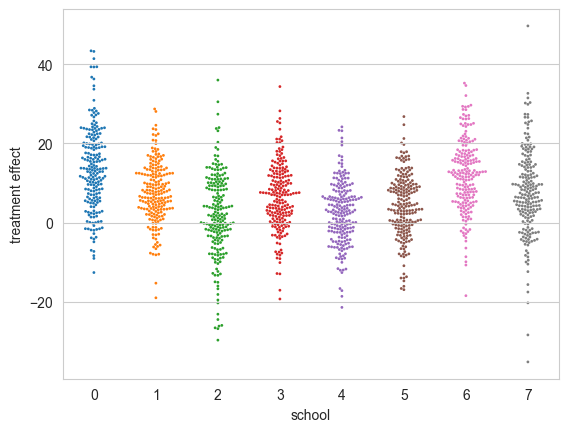

In [29]:
# plot the results (pangolin not used here)
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
sns.swarmplot(np.array(theta_samps)[:,::50].T,s=2,zorder=0)
plt.xlabel('school')
plt.ylabel('treatment effect');

Notice how the schools with high observed effects get pulled towards the mean, while schols with
low observed effects get pulled up. Schools with lower standard deviations have tighter posteriors.

Alternatively, you can define the model using "loops" (and experimental feature)

In [30]:
# alternate model definition using loops
mu = pg.normal(0,10)
tau = pg.exp(pg.normal(5,1))
theta = pg.interface.slot()
y = pg.interface.slot()
my_treatment_stddevs = pg.makerv(stddevs) # must convert to RV to make loops work
with pg.interface.Loop(8) as i:
    theta[i] = pg.normal(mu,tau)
    y[i] = pg.normal(theta[i],my_treatment_stddevs[i])

In [31]:
# print out ir
pg.interface.print_upstream(theta,y)

shape | statement
----- | ---------
()    | a = 0
()    | b = 10
()    | c ~ normal(a,b)
()    | d = 5
()    | e = 1
()    | f ~ normal(d,e)
()    | g = exp(f)
(8,)  | h ~ VMap(normal,('∅', '∅'),8)(c,g)
(8,)  | i = [15 10 ... 10 18]
(8,)  | j ~ VMap(normal,(0, 0),8)(h,i)


In [32]:
# inference
[theta_samps] = pg.inference.numpyro.sample_flat([theta], [y], [np.array(observed_effects)])

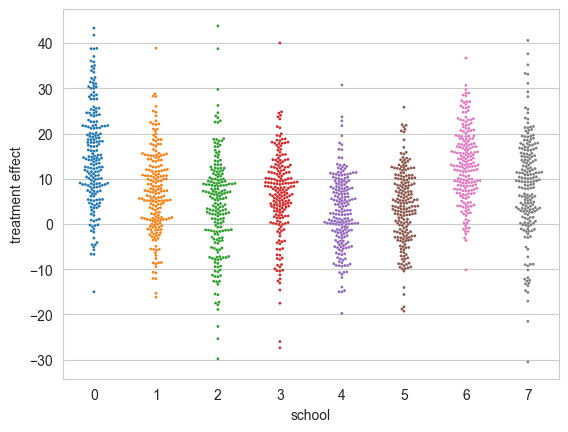

In [33]:
# plot
sns.swarmplot(theta_samps[::50,:],s=2)
plt.xlabel('school')
plt.ylabel('treatment effect');

In [ ]:
# function tioa    